Лабораторная работа №2. Реализация глубокой нейронной сети


In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow и tf.keras
!python3 -m pip install keras
import tensorflow as tf
from tensorflow import keras
from keras import regularizers


# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pdb
from six.moves import cPickle as pickle
import os
from scipy import ndimage

In [20]:
def extract_dataset():
    with open('../data/notMNIST_sanit.pickle', 'rb') as f:
        data = pickle.load(f)
    return data

def image_name(index):
  return chr(ord('A') + index)

In [22]:
dataset = extract_dataset()
train_images = dataset['train_dataset']
train_labels = dataset['train_labels']
valid_images = dataset['valid_dataset']
valid_labels = dataset['valid_labels']
test_images = dataset['test_dataset']
test_labels = dataset['test_labels']

1: Реализуйте полносвязную нейронную сеть с помощью библиотеки Tensor Flow.
В качестве алгоритма оптимизации можно использовать, например стохастический градиент (Stochastic Gradient Descent, SGD). Определите количество скрытых слоев от 1 до 5, количество нейронов в каждом из слоев до нескольких сотен, а также их функции активации (кусочно-линейная, сигмоидная, гиперболический тангенс и т.д.).


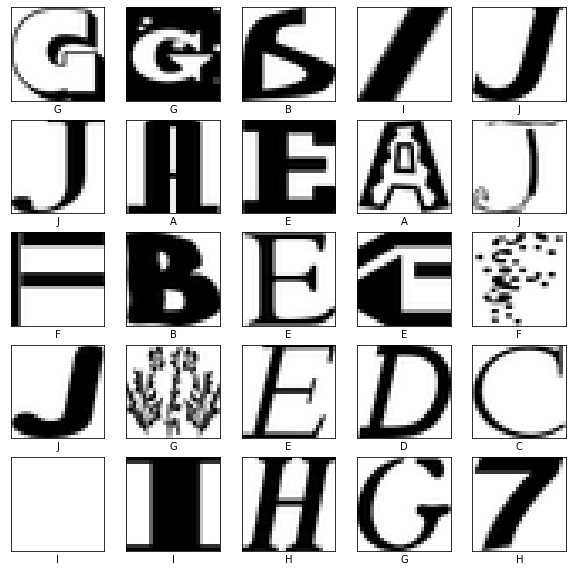

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(image_name(train_labels[i]))
plt.show()

In [26]:
# Flatten преобразует формат изображения из двумерного массива (28 на 28 пикселей)
# в одномерный (размерностью 28 * 28 = 784 пикселя)
# Dense - это полносвязные нейронные слои.
baseline_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(20, activation='sigmoid'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [28]:
baseline_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

baseline_model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

baseline_model.summary()

baseline_history = baseline_model.fit(train_images,
                                      train_labels,
                                      epochs=10,
                                      validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = baseline_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 200000 samples, validate on 16911 samples
Epoch 1/10
200000/200000 [==============================] - 68s 341us/sample - loss: 0.8498 - accuracy: 0.7832 - sparse_categorical_crossentropy: 0.8498 - val_loss: 0.6804 - val_accuracy: 0.8140 - 

Задание 2.
Как улучшилась точность классификатора по сравнению с логистической регрессией?

Логистическая регрессия давала результат в 0.8985 точности, нейронная сеть с тремя слоями выдает результат уже лучше: 0.9144495.

3: Используйте регуляризацию и метод сброса нейронов (dropout) для борьбы с переобучением.
Как улучшилось качество классификации?

In [30]:
#3.1 Регуляризация
# https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#add_weight_regularization

l2_regularization = 1e-4

l2_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dense(10, activation='softmax')
])

l2_model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

l2_model_history = l2_model.fit(train_images,
                                train_labels,
                                epochs=10,
                                validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = l2_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Train on 200000 samples, validate on 16911 samples
Epoch 1/10
200000/200000 [==============================] - 29s 146us/sample - loss: 0.8656 - accuracy: 0.7867 - sparse_categorical_crossentropy: 0.8355 - val_loss: 0.7207 - val_accuracy: 0.8153 - val_sparse_categorical_crossentropy: 0.6899
Epoch 2/10
200000/200000 [==============================] - 29s 147us/sample - loss: 0.6569 - accuracy: 0.8297 - sparse_categorical_crossentropy: 0.6258 - val_loss: 0.6781 - val_accuracy: 0.8214 - val_sparse_categorical_crossentropy: 0.6469
Epoch 3/10
200000/200000 [==============================] - 25s 124us/sample - loss: 0.6189 - accuracy: 0.8367 - sparse_categorical_crossentropy: 0.5875 - val_loss: 0.6426 - val_accuracy: 0.8263 - val_sparse_categorical_crossentropy: 0.6110
Epoch 4/10
200000/200000 [==============================] - 27s 134us/sample - loss: 0.5889 - accuracy: 0.8421 - sparse_categorical_crossentropy: 0.5570 - val_loss: 0.6175 - val_accuracy: 0.8311 - val_sparse_categorical_crosse

In [32]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_' + key],
                        '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])
    
    plt.show()

Регуляризация показала худшие результаты, чем исходная модель (0.9094037 против 0.9144495).

In [34]:
# 3.2 метод сброса нейронов

dropout_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

dropout_model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

dropout_model_history = dropout_model.fit(train_images,
                                train_labels,
                                epochs=10,
                                validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = dropout_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Train on 200000 samples, validate on 16911 samples
Epoch 1/10
200000/200000 [==============================] - 28s 140us/sample - loss: 1.4125 - accuracy: 0.5353 - sparse_categorical_crossentropy: 1.4125 - val_loss: 0.8015 - val_accuracy: 0.7839 - val_sparse_categorical_crossentropy: 0.8015
Epoch 2/10
200000/200000 [==============================] - 27s 135us/sample - loss: 0.9434 - accuracy: 0.7279 - sparse_categorical_crossentropy: 0.9434 - val_loss: 0.6895 - val_accuracy: 0.8017 - val_sparse_categorical_crossentropy: 0.6895
Epoch 3/10
200000/200000 [==============================] - 27s 135us/sample - loss: 0.8337 - accuracy: 0.7610 - sparse_categorical_crossentropy: 0.8337 - val_loss: 0.6497 - val_accuracy: 0.8078 - val_sparse_categorical_crossentropy: 0.6497
Epoch 4/10
200000/200000 [==============================] - 27s 137us/sample - loss: 0.7810 - accuracy: 0.7752 - sparse_categorical_crossentropy: 0.7810 - val_loss: 0.6248 - val_accuracy: 0.8134 - val_sparse_categorical_crosse

Точность на проверочных данных: (0.890367 против 0.9144495 у исходной модели).

In [36]:
# 3.3 регуляризация + дропаут

l2_dropout_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

l2_dropout_model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

l2_dropout_model_history = l2_dropout_model.fit(train_images,
                                train_labels,
                                epochs=10,
                                validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = l2_dropout_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Train on 200000 samples, validate on 16911 samples
Epoch 1/10
200000/200000 [==============================] - 27s 135us/sample - loss: 1.4132 - accuracy: 0.5480 - sparse_categorical_crossentropy: 1.3836 - val_loss: 0.8084 - val_accuracy: 0.7903 - val_sparse_categorical_crossentropy: 0.7770
Epoch 2/10
200000/200000 [==============================] - 26s 130us/sample - loss: 0.9587 - accuracy: 0.7299 - sparse_categorical_crossentropy: 0.9261 - val_loss: 0.7125 - val_accuracy: 0.8040 - val_sparse_categorical_crossentropy: 0.6790
Epoch 3/10
200000/200000 [==============================] - 26s 129us/sample - loss: 0.8569 - accuracy: 0.7619 - sparse_categorical_crossentropy: 0.8225 - val_loss: 0.6756 - val_accuracy: 0.8117 - val_sparse_categorical_crossentropy: 0.6405
Epoch 4/10
200000/200000 [==============================] - 26s 129us/sample - loss: 0.8073 - accuracy: 0.7777 - sparse_categorical_crossentropy: 0.7716 - val_loss: 0.6547 - val_accuracy: 0.8154 - val_sparse_categorical_crosse

Точность на проверочных данных: ( 0.89220184 против 0.9144495 у исходной модели).

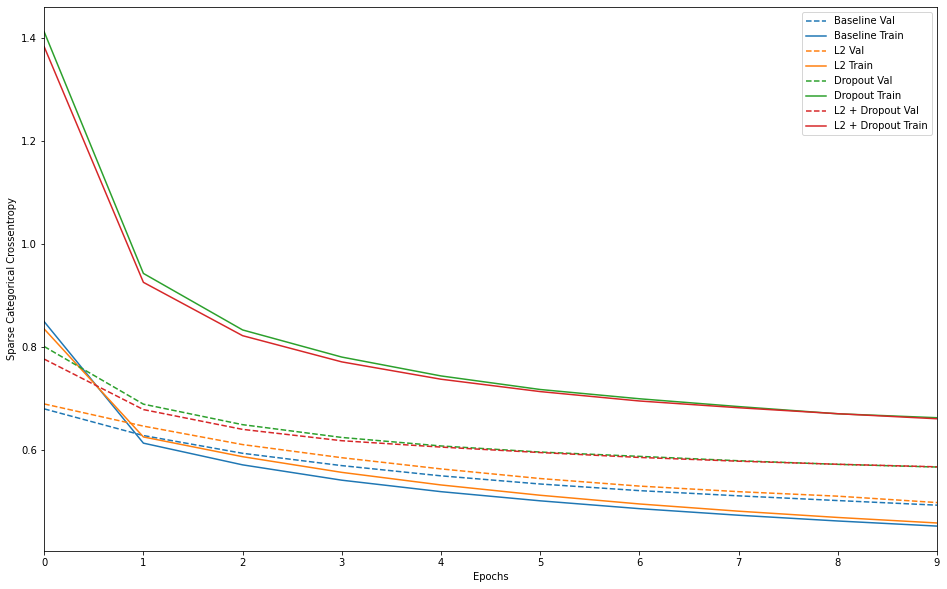

In [37]:
plot_history(
    [
        ('baseline', baseline_history),
        ('l2', l2_model_history),
        ('dropout', dropout_model_history),
        ('l2 + dropout', l2_dropout_model_history)
    ],
             key='sparse_categorical_crossentropy')


В итоге, дропаут только ухудшил результат модели, регуляризация её не ухудшила, но и лучших результатов не показала. Можно сделать вывод, что так как эти методы применяются для борьбы с переобучением модели, то если они ничего не улучшают, значит модель изначально не была переобучена.

Задание 4.
Воспользуйтесь динамически изменяемой скоростью обучения (learning rate).
Наилучшая точность, достигнутая с помощью данной модели составляет 97.1%.
Какую точность демонстрирует Ваша реализованная модель?

In [38]:
# Adagrad

adagrad_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
adagrad_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

adagrad_model.summary()

adagrad_history = adagrad_model.fit(train_images,
                                      train_labels,
                                      epochs=10,
                                      validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = adagrad_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_43 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_44 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 200000 samples, validate on 16911 samples
Epoch 1/10
200000/200000 [==============================] - 28s 138us/sample - loss: 0.7055 - accuracy: 0.8119 - sparse_categorical_crossentropy: 0.7055 - val_loss: 0.6278 - val_accuracy: 0.8242 -

In [39]:
# Adadelta

# Adadelta - это расширение Adagrad,
# которое стремится уменьшить свою агрессивную,
# монотонно уменьшающуюся скорость обучения.

adadelta_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
adadelta_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

adadelta_model.summary()

adadelta_history = adadelta_model.fit(train_images,
                                      train_labels,
                                      epochs=10,
                                      validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = adadelta_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_46 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_47 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 200000 samples, validate on 16911 samples
Epoch 1/10
200000/200000 [==============================] - 27s 135us/sample - loss: 0.5920 - accuracy: 0.8335 - sparse_categorical_crossentropy: 0.5920 - val_loss: 0.5313 - val_accuracy: 0.8425 -

In [40]:
# RMSprop

# RMSprop очень просто настраивает метод Адаграда,
# пытаясь уменьшить его агрессивное, монотонно убывающее обучение.

rms_prop_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
rms_prop_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

rms_prop_model.summary()

rms_prop_history = rms_prop_model.fit(train_images,
                                      train_labels,
                                      epochs=10,
                                      validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = rms_prop_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_49 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_50 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 200000 samples, validate on 16911 samples
Epoch 1/10
200000/200000 [==============================] - 28s 140us/sample - loss: 0.5174 - accuracy: 0.8470 - sparse_categorical_crossentropy: 0.5174 - val_loss: 0.4721 - val_accuracy: 0.8589 -

In [41]:
# Adam

# Adam - это обновление оптимизатора RMSProp,
# похожее на RMSprop с динамикой.

adam_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='sigmoid'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
adam_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

adam_model.summary()

adam_history = adam_model.fit(train_images,
                                      train_labels,
                                      epochs=10,
                                      validation_data=(valid_images, valid_labels))

test_loss, test_acc, _ = adam_model.evaluate(test_images,  test_labels, verbose=2)

print('\nТочность на проверочных данных:', test_acc)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_52 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_53 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 200000 samples, validate on 16911 samples
Epoch 1/10
200000/200000 [==============================] - 26s 128us/sample - loss: 0.5179 - accuracy: 0.8463 - sparse_categorical_crossentropy: 0.5179 - val_loss: 0.4775 - val_accuracy: 0.8578 -

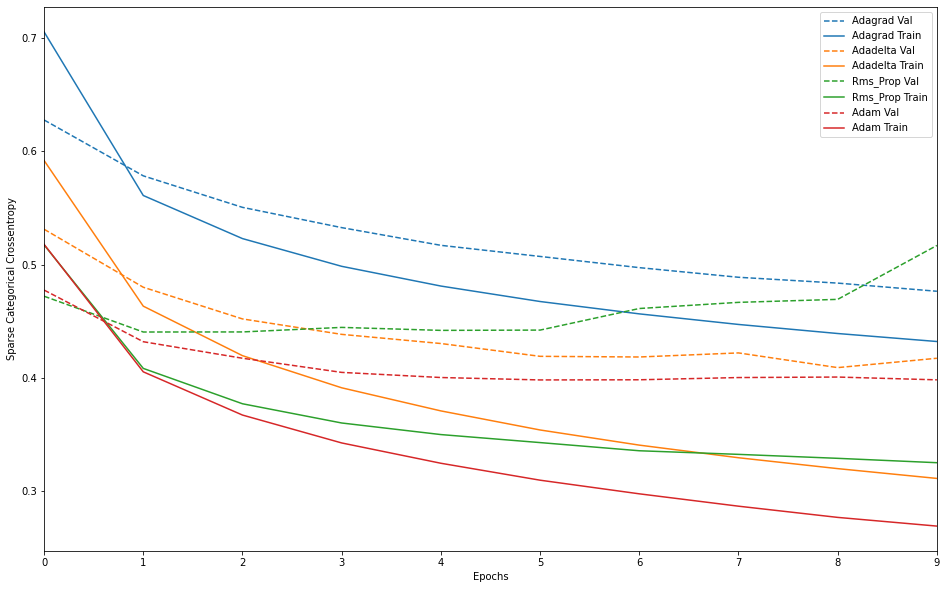

In [42]:
plot_history(
    [
        ('adagrad', adagrad_history),
        ('adadelta', adadelta_history),
        ('rms_prop', rms_prop_history),
        ('adam', adam_history)
    ],
    key='sparse_categorical_crossentropy')